Brian Blaylock  
June 14, 2018

# GLM: Proximity to fires
I am interested in showing how close convective activity is to a fire and if it is getting closer or further away. I will do this using data from the Geostationary Lightning Mapper (GLM).

In [1]:
%matplotlib inline

import os
from datetime import datetime, timedelta
import matplotlib.pyplot as plt
from mpl_toolkits.basemap import Basemap
import numpy as np
from pyproj import Geod

import sys
sys.path.append('/uufs/chpc.utah.edu/common/home/u0553130/pyBKB_v2')
from BB_GOES16.get_GLM import get_GLM_files_for_range, accumulate_GLM
from BB_rose.distancerose import WindroseAxes
from BB_downloads.HRRR_S3 import get_hrrr_variable, hrrr_subset

In [2]:
eDATE = datetime(2018, 6, 14, 21)
prev30 = eDATE - timedelta(minutes=30)
prev60 = eDATE - timedelta(minutes=60)
prev90 = eDATE - timedelta(minutes=90)

GLM0 = accumulate_GLM(get_GLM_files_for_range(prev90, prev60)) # 60-90 minutes ago
GLM = accumulate_GLM(get_GLM_files_for_range(prev60, prev30)) # 30-60 minutes ago
GLM2 = accumulate_GLM(get_GLM_files_for_range(prev30, eDATE)) # 0-30 minutes ago

## Map

In [3]:
# 416 fire in colorado
FIRE = (37.461,-107.808)

In [4]:
H = get_hrrr_variable(eDATE, 'UVGRD:500 mb', verbose=False)

In [5]:
H = hrrr_subset(H, half_box=250, lat=FIRE[0], lon=FIRE[1])

 >> Requested Center lat: 37.461	 lon: -107.808
 >>     Plucked HRRR lat: 37.4744761726	 lon: -107.791958885
 >>     Plucked from   x: 508	   y: 597
 >> Size of subset: 500 x 500 grid points


In [6]:
m = Basemap(resolution='i', projection='cyl', area_thresh=1500,\
            llcrnrlon=FIRE[1]-3.5, llcrnrlat=FIRE[0]-3.5, \
            urcrnrlon=FIRE[1]+3.5, urcrnrlat=FIRE[0]+3.5)

In [7]:
miles = 150
meters = 1609.344 * miles

g = Geod(ellps='clrk66')


In [8]:
def plot_radius(r):
    """
    r - radius in meters
    """
    endlon = []
    endlat = []
    for i in range(360):
        fwdlon, fwdlat, backaz = g.fwd(FIRE[1], FIRE[0], i, r)
        endlon.append(fwdlon)
        endlat.append(fwdlat)
    m.plot(endlon, endlat,
           color='crimson',
           linewidth=3,
           latlon=True,
           zorder=1)

def plot_winds(H):
    thin = 30
    m.barbs(H['lon'][::thin,::thin], H['lat'][::thin,::thin],
            H['UGRD'][::thin,::thin], H['VGRD'][::thin,::thin],
            length=5,
            color='green',
            latlon=True,
            barb_increments={'half':2.5, 'full':5,'flag':25},
            zorder=5)
    plt.xlabel(r'HRRR 500 hPa Winds: Half, Full, Flag = 2.5, 5, 25 ms$\mathregular{^{-1}}$, respectively')

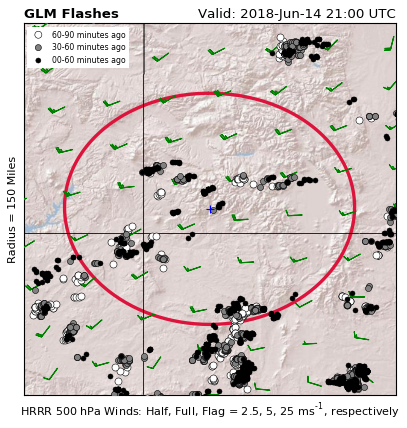

In [55]:
plt.figure(figsize=[6,6])

plot_radius(1609.344*miles)
plot_winds(H)

m.scatter(GLM0['longitude'], GLM0['latitude'],
          s=40, edgecolor='k', linewidth=.5,
          color='w',
          latlon=True,
          label='60-90 minutes ago',
          zorder=10)
m.scatter(GLM['longitude'], GLM['latitude'],
          s=30, edgecolor='k', linewidth=.5,
          color='grey',
          latlon=True,
          label='30-60 minutes ago',
          zorder=10)
m.scatter(GLM2['longitude'], GLM2['latitude'],
          s=20, edgecolor='k', linewidth=.5,
          color='k',
          latlon=True,
          label='00-60 minutes ago',
          zorder=10)

m.scatter(FIRE[1], FIRE[0], s=50, marker='+', zorder=10)

m.drawstates()
m.drawcountries()
m.arcgisimage(service='World_Shaded_Relief', xpixels=500, dpi=100)

plt.title('GLM Flashes', fontweight="semibold", loc='left')
plt.title(eDATE.strftime('Valid: %Y-%b-%d %H:%M UTC'), loc='right')
plt.ylabel('Radius = %s Miles' % miles)

leg = plt.legend(scatterpoints=1, framealpha=1, loc=2, fontsize=7)
leg.get_frame().set_linewidth(0)

## Histogram

In [10]:
# Perform distance calculation between fire and flash
FIRE_lon = FIRE[1]*np.ones_like(GLM0['longitude'])
FIRE_lat = FIRE[0]*np.ones_like(GLM0['latitude'])
azimuth0, backward0, distances0 = g.inv(FIRE_lon, FIRE_lat, GLM0['longitude'], GLM0['latitude'])

FIRE_lon = FIRE[1]*np.ones_like(GLM['longitude'])
FIRE_lat = FIRE[0]*np.ones_like(GLM['latitude'])
azimuth, backward, distances = g.inv(FIRE_lon, FIRE_lat, GLM['longitude'], GLM['latitude'])

FIRE_lon = FIRE[1]*np.ones_like(GLM2['longitude'])
FIRE_lat = FIRE[0]*np.ones_like(GLM2['latitude'])
azimuth2, backward2, distances2 = g.inv(FIRE_lon, FIRE_lat, GLM2['longitude'], GLM2['latitude'])


# convert distances from meters to miles
distances0 = distances0/1609.344
distances = distances/1609.344
distances2 = distances2/1609.344

# convert negative azimuth to positive degrees from north
azimuth0[azimuth0<0] += 360
azimuth[azimuth<0] += 360
azimuth2[azimuth2<0] += 360

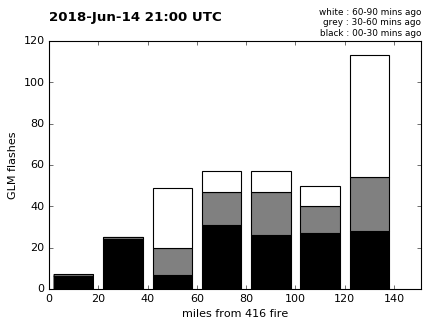

In [11]:
plt.hist([distances2[distances2<miles], distances[distances<miles],distances0[distances0<miles]],
         stacked=True,
         color=['k', 'grey', 'w'],
         bins=range(0,151,20))
plt.xlim(0,151)
plt.xticks(range(0,151,20))
plt.xlabel('miles from 416 fire')
plt.ylabel('GLM flashes')
plt.title(eDATE.strftime('%Y-%b-%d %H:%M UTC\n'), loc='left', fontweight='semibold')
plt.title('white : 60-90 mins ago\ngrey : 30-60 mins ago\nblack : 00-30 mins ago', loc='right', fontsize=8)

## Lightning Rose

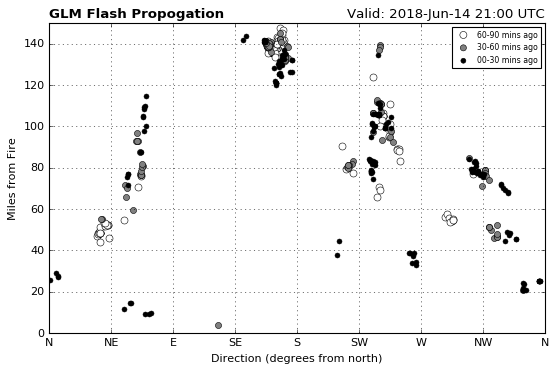

In [56]:
plt.figure(figsize=[8,5])

plt.scatter(azimuth0[distances0<miles], distances0[distances0<miles],
            color='white',
            s=40, edgecolor='k', linewidth=.5,
            label='60-90 mins ago')
plt.scatter(azimuth[distances<miles], distances[distances<miles],
            color='grey',
            s=30, edgecolor='k', linewidth=.5,
            label='30-60 mins ago')
plt.scatter(azimuth2[distances2<miles], distances2[distances2<miles],
            color='k',
            s=20, edgecolor='k', linewidth=.5,
            label='00-30 mins ago')
plt.xlabel('Direction (degrees from north)')
plt.ylim([0,miles])
plt.xlim([0,360])
plt.xticks(range(0,361,45), ['N', 'NE', 'E', 'SE', 'S', 'SW', 'W', 'NW', 'N'])
plt.grid()
plt.title('GLM Flash Propogation', loc='left', fontweight='semibold')
plt.title(eDATE.strftime('Valid: %Y-%b-%d %H:%M UTC'), loc='right')

plt.ylabel('Miles from Fire')
leg = plt.legend(scatterpoints=1, framealpha=1, loc='best', fontsize=7)
leg.get_frame().set_linewidth(1)

In [13]:
#A quick way to create new windrose axes...
def new_axes():
    fig = plt.figure(figsize=(6,8), dpi=80, facecolor='w', edgecolor='w')
    rect = [0.1, 0.1, 0.8, 0.8]
    ax = WindroseAxes(fig, rect, axisbg='w')
    fig.add_axes(ax)
    return ax

#...and adjust the legend box
def set_legend(ax):
    l = ax.legend()
    plt.setp(l.get_texts())
    leg = plt.legend(loc='center left', bbox_to_anchor=(1, 0.5),prop={'size':15})
    leg.draw_frame(False)

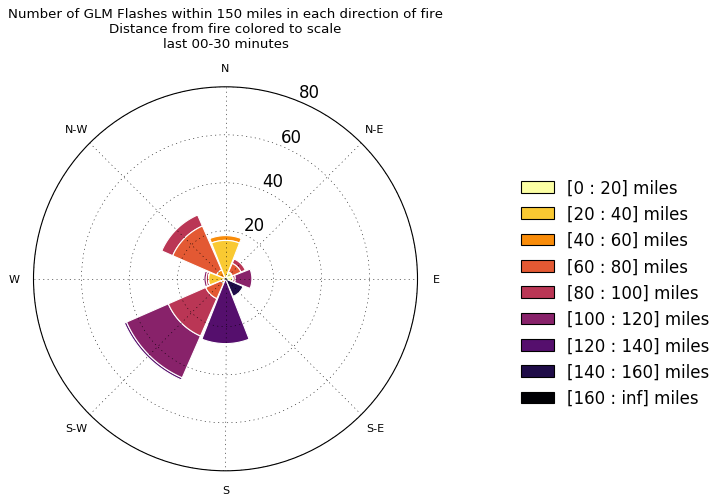

In [31]:
ws = distances2[distances2<miles]
wd = azimuth2[distances2<miles]

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles+21,20),
       opening=.95, edgecolor='w',
       cmap=cm.inferno_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(20,105,20))
ax.set_yticklabels(np.arange(20,105,20), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
#ax.set_rmax(np.floor(max(wd_freq)/5)*5+5) #set rmax to upper number divisible by 5
ax.set_rmax(80)

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\nlast 00-30 minutes\n')

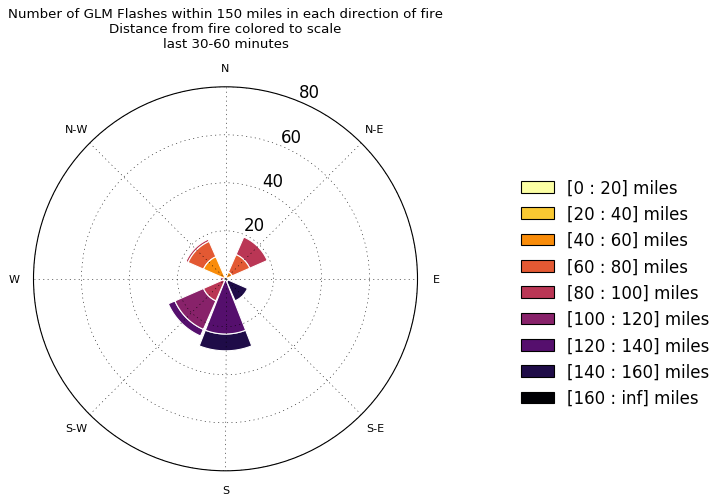

In [32]:
ws = distances[distances<miles]
wd = azimuth[distances<miles]

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles+21,20),
       opening=.95, edgecolor='w',
       cmap=cm.inferno_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(20,105,20))
ax.set_yticklabels(np.arange(20,105,20), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
#ax.set_rmax(np.floor(max(wd_freq)/5)*5+5) #set rmax to upper number divisible by 5
ax.set_rmax(80)

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\nlast 30-60 minutes\n')

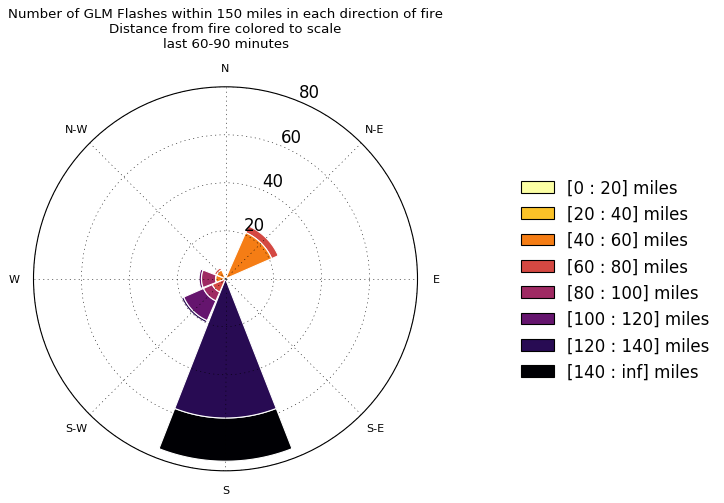

In [38]:
ws = distances0[distances0<miles]
wd = azimuth0[distances0<miles]

import matplotlib.cm as cm
ax = new_axes()
#ax.contourf(wd, ws, nsector=16, bins=np.arange(0, miles, 20), cmap=cm.viridis)
ax.bar(wd, ws, nsector = 8, normed=False,
       bins = np.arange(0,miles,20),
       opening=.95, edgecolor='w',
       cmap=cm.inferno_r)

leg = plt.legend(loc='bottom left', bbox_to_anchor=(1.8, 0.8),prop={'size':15})
leg.draw_frame(False)

plt.grid(True)
plt.yticks(np.arange(20,105,20))
ax.set_yticklabels(np.arange(20,105,20), fontsize = 15)

table = ax._info['table']
wd_freq = np.sum(table, axis=0)
#ax.set_rmax(np.floor(max(wd_freq)/5)*5+5) #set rmax to upper number divisible by 5
ax.set_rmax(80)

plt.title('Number of GLM Flashes within 150 miles in each direction of fire\nDistance from fire colored to scale\nlast 60-90 minutes\n')